In [40]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

# Base Models
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor

# Ensemble Models
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor

# Function to calculate RMSE
def rmse(y_true, y_pred):
    """Calculates the Root Mean Squared Error (RMSE)."""
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Load the dataset (Assuming 'hour.csv' is in the current working directory)
df = pd.read_csv('hour.csv')
print("Data loaded successfully. Shape:", df.shape)

Data loaded successfully. Shape: (17379, 17)


Here, I drop the irrelevant columns and use One-Hot Encoding for categorical features.

In [41]:
# Drop irrelevant columns
columns_to_drop = ['instant', 'dteday', 'casual', 'registered']
if not df.empty:
    df_processed = df.drop(columns=columns_to_drop, axis=1, errors='ignore')

# The target variable is 'cnt' ]
TARGET = 'cnt'

#  categorical features that need One-Hot Encoding
categorical_features = ['season', 'weathersit', 'mnth', 'hr', 'weekday']

# Define numerical features (remaining columns excluding target)
numerical_features = [col for col in df_processed.columns if col not in categorical_features and col != TARGET]

# Create a Column Transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ],
    remainder='passthrough' # Keep numerical columns as they are
)

# Separate features (X) and target (y)
X = df_processed.drop(columns=[TARGET])
y = df_processed[TARGET]

# Apply preprocessing and get the processed feature matrix
X_processed = preprocessor.fit_transform(X)

# Get feature names after one-hot encoding for better interpretability (optional but recommended)
feature_names = list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))
feature_names.extend(numerical_features)
X_processed_df = pd.DataFrame(X_processed, columns=feature_names)

print("\nProcessed Features Shape:", X_processed_df.shape)


Processed Features Shape: (17379, 58)


Next, I split the preprocessed data into training and testing sets using a 70/30 split.

In [42]:

X_train, X_test, y_train, y_test = train_test_split(
    X_processed_df, y, test_size=0.3, random_state=42
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")

Training set size: 12165 samples
Testing set size: 5214 samples


To evaluate a baseline, I used a decision tree and linear regression model

In [43]:
# 1. Single Decision Tree Regressor
dt_baseline = DecisionTreeRegressor(max_depth=6, random_state=42)
dt_baseline.fit(X_train, y_train)
dt_pred = dt_baseline.predict(X_test)
dt_rmse = rmse(y_test, dt_pred)
print(f"Decision Tree Baseline RMSE: {dt_rmse:.2f}")

# 2. Single Linear Regression Model
lr_baseline = LinearRegression()
lr_baseline.fit(X_train, y_train)
lr_pred = lr_baseline.predict(X_test)
lr_rmse = rmse(y_test, lr_pred)
print(f"Linear Regression Baseline RMSE: {lr_rmse:.2f}")

# Determine the overall baseline model [cite: 28]
if dt_rmse < lr_rmse:
    BASE_MODEL_NAME = "Decision Tree"
    BASE_RMSE = dt_rmse
else:
    BASE_MODEL_NAME = "Linear Regression"
    BASE_RMSE = lr_rmse

print(f"\nBest Model for base performance: {BASE_MODEL_NAME} with RMSE = {BASE_RMSE:.2f}")

# Dictionary to store results for final comparison
results = {BASE_MODEL_NAME: BASE_RMSE}

Decision Tree Baseline RMSE: 118.20
Linear Regression Baseline RMSE: 100.46

Best Model for base performance: Linear Regression with RMSE = 100.46


Next, I implemented a bagging regressor using the Decision Tree (max_depth=6) as the base estimator. Bagging first creates mini datasets instead of training one model on the full dataset by randomly picking data points with replacement
For each mini-dataset, a separate model is trained. These models are of the same type, in this case decision trees.Once all models have been trained, they average their predictions. It reduces overfitting by combining predictions from multiple models, making it  effective for high-variance models like decision trees.

In [44]:

bagging_model = BaggingRegressor(
    estimator=DecisionTreeRegressor(max_depth=6, random_state=42),
    n_estimators=50, # Use at least 50 estimators
    random_state=42,
    n_jobs=-1 # Use all available cores
)

bagging_model.fit(X_train, y_train)
bagging_pred = bagging_model.predict(X_test)
bagging_rmse = rmse(y_test, bagging_pred)

results['Bagging Regressor'] = bagging_rmse
print(f"Bagging Regressor RMSE: {bagging_rmse:.2f}")

# Variance Reduction
variance_discussion = (
    f"The Bagging Regressor achieved an RMSE of {bagging_rmse:.2f} compared to the single Decision Tree RMSE of {dt_rmse:.2f}.\n"
)
print(variance_discussion)

Bagging Regressor RMSE: 113.50
The Bagging Regressor achieved an RMSE of 113.50 compared to the single Decision Tree RMSE of 118.20.



As expected, The bagging regressor has a smaller RMSE. This is because it reduces overfitting by combining predictions from multiple models. It improves accuracy by averaging the outputs of multiple models. Bagging is less sensitive to noisy data or outliers, as it uses various subsets of the training data for model training.

In [45]:

gbr_model = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

gbr_model.fit(X_train, y_train)
gbr_pred = gbr_model.predict(X_test)
gbr_rmse = rmse(y_test, gbr_pred)

results['Gradient Boosting Regressor'] = gbr_rmse
print(f"\nGradient Boosting Regressor RMSE: {gbr_rmse:.2f}")


bias_discussion = (
    f"The Gradient Boosting Regressor achieved an RMSE of {gbr_rmse:.2f}.\n"
    f"This is better than the single model baseline (RMSE: {BASE_RMSE:.2f}) and the Bagging ensemble (RMSE: {bagging_rmse:.2f}).\n"
)
print(bias_discussion)


Gradient Boosting Regressor RMSE: 79.40
The Gradient Boosting Regressor achieved an RMSE of 79.40.
This is better than the single model baseline (RMSE: 100.46) and the Bagging ensemble (RMSE: 113.50).



As expected the Gradient Boosting Regressor had lower RMSE than the bagging ensemble and the single model baseline. It builds models one after another, where each new model focuses on fixing the mistakes of all previous models combined. Each new tree focuses on minimizing the residual errors, the differences between actual and predicted values rather than learning directly from the original targets.

Next I used a Stacking regressor. Stacking combines the predictions of 3 Level-0 Base Learners using a Level-1 Meta-Learner. The Base Learners make independent predictions, and the Meta-Learner is trained to learn the optimal way to combine these predictions  to minimize the final error. The key benefit is exploiting the strengths of different types of models

In [46]:
# Base Learners (Level-0)
level0_learners = [
    ('knn', KNeighborsRegressor(n_neighbors=5)), # K-Nearest Neighbors Regressor
    ('bagging', bagging_model),                  # Bagging Regressor
    ('gbr', gbr_model)                           # Gradient Boosting Regressor
]

#Meta-Learner (Level-1)
# Ridge Regression is a stable choice for combining predictions
meta_learner = Ridge()

stacking_model = StackingRegressor(
    estimators=level0_learners,
    final_estimator=meta_learner,
    cv=5, # Use cross-validation to generate level-0 predictions for the meta-learner
    n_jobs=-1
)

print("\nTraining Stacking Regressor...")
stacking_model.fit(X_train, y_train)


Training Stacking Regressor...


StackingRegressor(cv=5,
                  estimators=[('knn', KNeighborsRegressor()),
                              ('bagging',
                               BaggingRegressor(estimator=DecisionTreeRegressor(max_depth=6,
                                                                                random_state=42),
                                                n_estimators=50, n_jobs=-1,
                                                random_state=42)),
                              ('gbr',
                               GradientBoostingRegressor(random_state=42))],
                  final_estimator=Ridge(), n_jobs=-1)

In [47]:
stacking_pred = stacking_model.predict(X_test)
stacking_rmse = np.sqrt(mean_squared_error(y_test, stacking_pred))

results['Stacking Regressor'] = stacking_rmse
print(f"Stacking Regressor RMSE: {stacking_rmse:.2f}")

Stacking Regressor RMSE: 69.04


In [48]:

print("Comparing  Model Performance (RMSE)" )
for model, score in sorted(results.items(), key=lambda item: item[1]):
    print(f"{model:<30}: {score:.2f}")


Comparing  Model Performance (RMSE)
Stacking Regressor            : 69.04
Gradient Boosting Regressor   : 79.40
Linear Regression             : 100.46
Bagging Regressor             : 113.50


Based on the results, the Stacking Regressor achieved the lowest RMSE, making it the best-performing model for this task.

The Stacking Regressor outperforms single models and simple as it uses different models and manages the bias-variance trade-off.
- The Decision Tree in the baseline is a high-variance, low-bias model which is prone to overfitting.
- Linear Regression is  a high-bias, low-variance model.
- Boosting effectively reduces bias.
- Bagging effectively reduces variance.

Stacking harnesses both these effects by incorporating models specifically designed to address each component of error.
Stacking uses a set of different base learners (KNN, Bagging, Gradient Boosting) which learn different aspects of the complex, non-linear relationships in the bike-share data
By feeding the predictions of these varied models to the Ridge Meta-Learner, the Meta-Learner learns the optimal, weighted combination that minimizes the overall remaining error, leading to the least RMSE

Then i tried to  plot  the prediction curves of the best single model (Linear Regression Baseline) and the best ensemble model (Stacking Regressor) across the first 48 sequential hours of the test set. The blue line tracks the Actual Count (Black Line) much more closely than the red line. This shows the Stacking model has learned the non-linear relationship more accurately probably from the Gradient Boosting base learner which focuses on reducing the bias.

The Stacking model also maintains stability. While it is more responsive to fluctuation than Linear regression baseline  its predictions are tightly grouped around the actual values. This shows it has better control over variance than a single, deep Decision Tree would have.

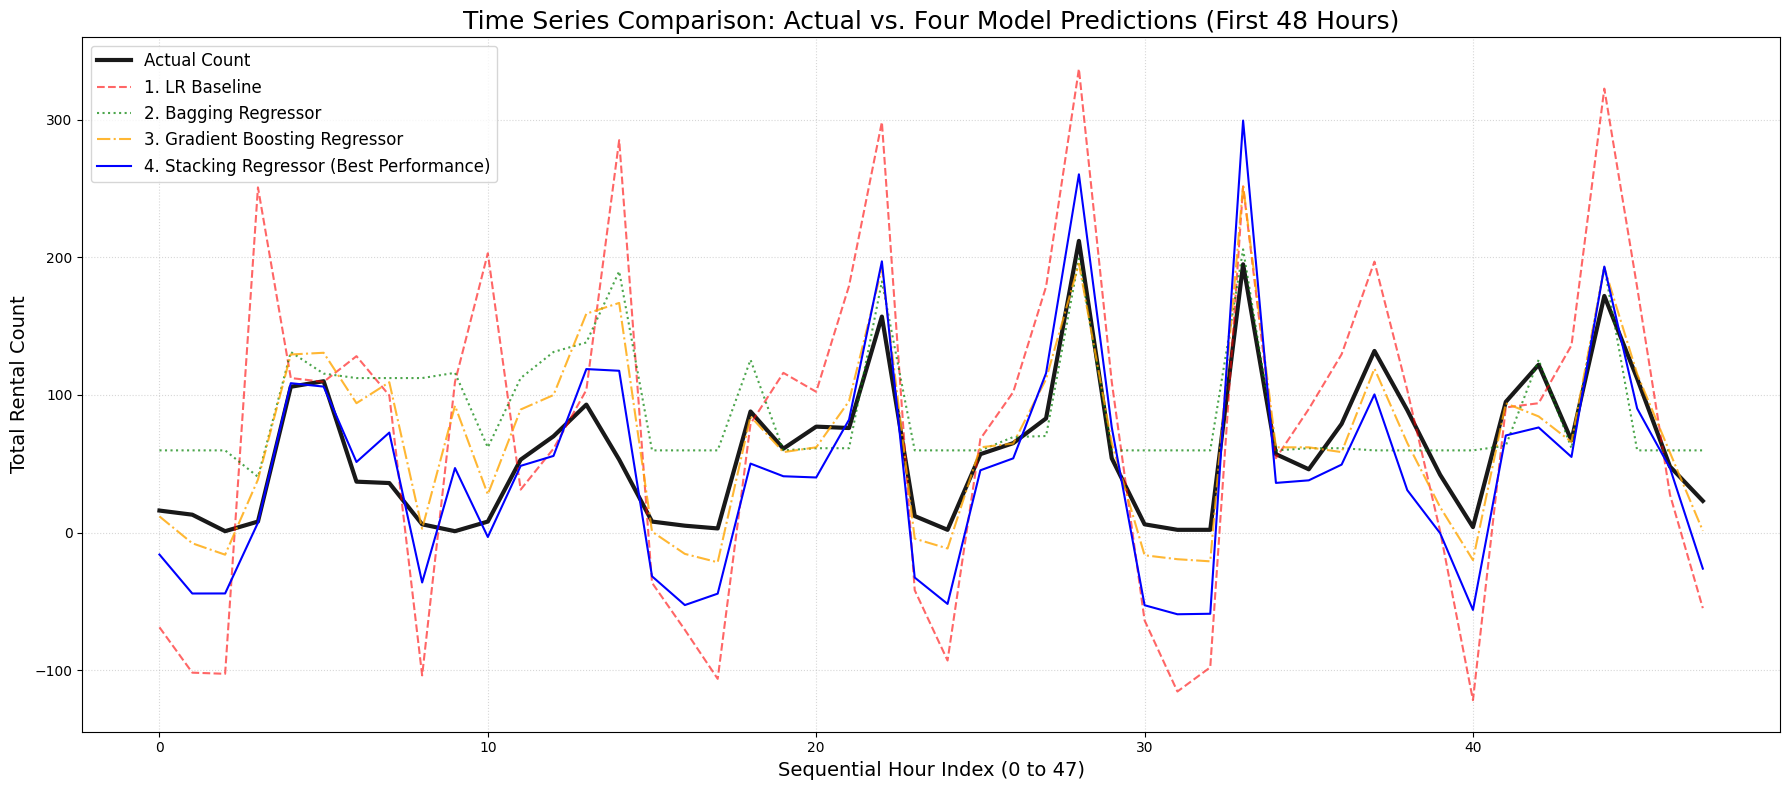

This plot visually demonstrates the  improvement of each ensemble technique.


In [49]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

lr_pred = lr_baseline.predict(X_test)
bagging_pred = bagging_model.predict(X_test)
gbr_pred = gbr_model.predict(X_test)
stacking_pred = stacking_model.predict(X_test)

plot_df = pd.DataFrame({
    'Actual': y_test,
    'LR Baseline (High Bias)': lr_pred,
    'Bagging Regressor (Variance Reduction)': bagging_pred,
    'Gradient Boosting Regressor (Bias Reduction)': gbr_pred,
    'Stacking Regressor (Optimal Ensemble)': stacking_pred
})

plot_df_sorted = plot_df.sort_index()

# first 48 sequential hours
sample_size = 48
sample_data = plot_df_sorted.head(sample_size)

plt.figure(figsize=(18, 8))

x_axis = np.arange(sample_size)

# 1. Actual Values
plt.plot(x_axis, sample_data['Actual'], label='Actual Count', color='black', linewidth=3, alpha=0.9)

# 2. Linear Regression Baseline (High Bias)
plt.plot(x_axis, sample_data['LR Baseline (High Bias)'], label='1. LR Baseline', linestyle='--', color='red', alpha=0.6)

# 3. Bagging Regressor (Improved Variance)
plt.plot(x_axis, sample_data['Bagging Regressor (Variance Reduction)'], label='2. Bagging Regressor', linestyle=':', color='green', alpha=0.7)

# 4. Gradient Boosting Regressor (Improved Bias)
plt.plot(x_axis, sample_data['Gradient Boosting Regressor (Bias Reduction)'], label='3. Gradient Boosting Regressor', linestyle='-.', color='orange', alpha=0.8)

# 5. Stacking Regressor (Optimal)
plt.plot(x_axis, sample_data['Stacking Regressor (Optimal Ensemble)'], label='4. Stacking Regressor (Best Performance)', linestyle='-', color='blue', linewidth=1.5)


plt.title('Time Series Comparison: Actual vs. Four Model Predictions (First 48 Hours)', fontsize=18)
plt.xlabel('Sequential Hour Index (0 to 47)', fontsize=14)
plt.ylabel('Total Rental Count', fontsize=14)
plt.legend(loc='upper left', fontsize=12)
plt.grid(True, linestyle=':', alpha=0.5)
plt.tight_layout()

plt.show()

print("This plot visually demonstrates the  improvement of each ensemble technique.")